## Обучаем первую модель на MNIST

План на сегодня: пишем первый пайплайн для обучения

1. Пытаемся понять, какие компоненты нам нужны для обучения любой модели
2. Выясняем, что многое уже есть в Pytorch
3. Собираем наш первый скрипт для обучения на датасете MNIST

### 1. Проектируем пайплайн для обучения модели

### 2. Разбираемся с данными

#### 2.1. Организуем доступ к данным с `torch.utils.data.Dataset`

In [1]:
from typing import Any
import torch
from torch.utils.data import Dataset



class MyDataset(Dataset):
    ...

In [2]:
dataset = MyDataset(10)
for i in range(len(dataset)):
    print(dataset[i])

(tensor([0, 1, 2]), tensor(2))
(tensor([3, 4, 5]), tensor(0))
(tensor([6, 7, 8]), tensor(3))
(tensor([ 9, 10, 11]), tensor(0))
(tensor([12, 13, 14]), tensor(0))
(tensor([15, 16, 17]), tensor(3))
(tensor([18, 19, 20]), tensor(0))
(tensor([21, 22, 23]), tensor(2))
(tensor([24, 25, 26]), tensor(0))
(tensor([27, 28, 29]), tensor(3))


#### 2.2. Пакуем данные в батчи с `torch.utils.data.Dataloader`

In [3]:
from torch.utils.data import DataLoader

my_loader = ...

In [4]:
for i, batch in enumerate(my_loader):
    x, y = batch
    if i == 0:
        print(x)
        print(y)

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])
tensor([2, 0, 3, 0])


#### 2.3. Посмотрим на MNIST

- какие атрибуты есть у объекта `torchvision.datasets.MNIST`?
- как выглядит одно наблюдение?

In [5]:
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    'data', 
    train=True, 
    download=True,    
    transform=transforms.ToTensor(),  # что это?
)
test_dataset = datasets.MNIST(
    'data', 
    train=False, 
    download=True,
    transform=transforms.ToTensor(),
)

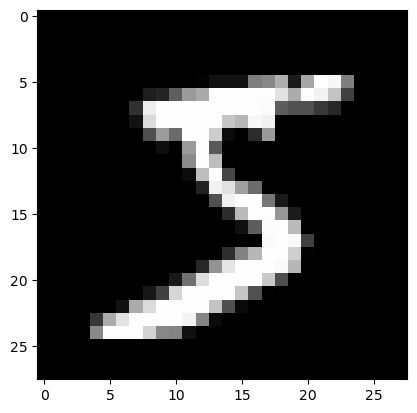

In [6]:
import matplotlib.pyplot as plt
image = ...
plt.imshow(image, cmap="gray")

Попробуем получить минибатч:

In [7]:
batch_size = 4
train_loader = ...
test_loader = ...

Что возвращает `iter()`?

In [8]:
batch: tuple[torch.Tensor, torch.Tensor] = next(iter(train_loader))
x, y = batch
print(x.shape)
print(y.shape)

torch.Size([4, 1, 28, 28])
torch.Size([4])


Со свёрточными сетями мы познакомимся позже, сейчас же мы будем экспериментировать с обычными полносвязными сетями, но для этого нам нужно будет преобразовать форму батча из `(batch_size, channels, width, height)` в `(batch_size, channels * width * height)`:

In [10]:
batch_size, channels, width, height = x.shape
input_dim = channels * width * height
# x.view((batch_size, -1)).shape

x.flatten(1).shape

torch.Size([4, 784])

Ура, с данными вроде разобрались! Теперь разберёмся с моделью

### 3. Реализуем модель с помощью `torch.nn.Module`

Для простоты будем строить небольшую нейронку из двух полносвязных слоёв и `tanh` в качестве функции активации.

Какие параметры должны быть в линейном слое?

In [11]:
hidden_dim = 128
# w1 = torch.randn((input_dim, hidden_dim), requires_grad=True)
# b1 = torch.randn(hidden_dim, requires_grad=True)

# h1 = x.view(-1, input_dim) @ w1 + b1
# print(h1.grad_fn)
# h1.shape

torch.Size([4, 128])

То же самое мы можем сделать с `torch.nn.Linear`:

In [12]:
l1 = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim)
print(l1.weight.shape)
print(l1.bias.shape)

h1 = l1(x.view(-1, input_dim))
print(h1.shape)
print(h1.grad_fn)

torch.Size([128, 784])
torch.Size([128])
torch.Size([4, 128])


Оказывается, в PyTorch есть огромное множество строительных блоков, из которых можно собирать архитектуры нейросетей. Давайте опишем все компоненты, которые нам нужны

In [56]:
output_dim = 10
l1 = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim)
l2 = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim)

def forward(x: torch.Tensor) -> torch.Tensor:
    h = l1.forward(x.flatten(1))
    h = torch.nn.functional.tanh(h)
    logits = l2.forward(h)
    probs = torch.nn.functional.softmax(logits, dim=-1)
    return probs

probs = forward(x)
print(probs.shape)
print(probs.grad_fn)

torch.Size([4, 10])


Получается некрасивая ситуация: функция `forward` зависит от глобальных переменных. Мы могли бы передать все параметры через аргументы, но что если их слишком много?



Для создания простых моделей с линейной последовательностью операций можно упаковывать модули в `torch.nn.Sequential`:

In [ ]:
sequential_model = ...

torch.Size([4, 10])


Более универсальный способ - спрятать всё внутрь класса-наследника `torch.nn.Module`

In [14]:
class SimpleNet(torch.nn.Module):
    ...


model = ...


torch.Size([4, 10])


Параметры модели:

In [15]:
next(model.named_parameters())

('l1.weight',
 Parameter containing:
 tensor([[ 0.0176,  0.0200,  0.0321,  ..., -0.0121,  0.0154,  0.0115],
         [ 0.0144, -0.0232,  0.0078,  ...,  0.0182,  0.0108,  0.0258],
         [-0.0009,  0.0103,  0.0095,  ...,  0.0182,  0.0213, -0.0125],
         ...,
         [-0.0119, -0.0236,  0.0213,  ..., -0.0165,  0.0082,  0.0055],
         [ 0.0053, -0.0217, -0.0217,  ...,  0.0262, -0.0151, -0.0075],
         [ 0.0015,  0.0002, -0.0051,  ...,  0.0228, -0.0268,  0.0126]],
        requires_grad=True))

Вручную обновлять значения стольких параметров очень неудобно. К счастью, за нас это сделает оптимизатор

### 4. Оптимизаторы

In [16]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [53]:
# получим предсказания и посчитаем ошибку
predictions = model.forward(x)
loss = torch.nn.functional.cross_entropy(predictions, y)
print(loss)
# рассчитаем градиенты и обновим параметры
loss.backward()
optimizer.step()

# не забудем почистить градиенты, мы не хотим их накапливать (всегда так?)
optimizer.zero_grad()


tensor(0.6921, grad_fn=<NllLossBackward0>)


### 5. Собираем всё воедино

Опишем, что мы делаем с каждым минибатчем данных:

In [233]:
def training_step(batch: tuple[torch.Tensor, torch.Tensor], model: torch.nn.Module, optimizer: torch.optim.Optimizer) -> torch.Tensor:
    # прогоняем батч через модель
    # оцениваем значение ошибки
    loss = ...
    # обновляем параметры
    # возвращаем значение функции ошибки для логирования
    return loss

In [ ]:
def test_step(batch: tuple[torch.Tensor, torch.Tensor], model: torch.nn.Module) -> torch.Tensor:
    loss = ...
    return loss

А теперь: что мы хотим делать в каждой эпохе?

Как насчёт метрик?

In [ ]:
def train_epoch(dataloader: DataLoader, model: torch.nn.Module, optimizer: torch.optim.Optimizer) -> ...:
    ...

Создадим модель, оптимизатор и загрузчики данных и запустим обучение: